### A compiled graph is called runnables. Any runnables can be added in the graph as a node.

#### create_react_agent creates a runnable.
  - Infact, create_react_agent is an abstraction to the graph nodes and edeges needed for the reAct reasoning pattern
  - The create_react_agent creates the graph and nodes and then compiles it to generate a runnable

In [13]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from typing import TypedDict, Annotated
import operator

# Define some tools for our sub-agent
@tool
def get_current_weather(location: str) -> str:
    """Get the current weather in a given location."""
    print("+++++++++++++>>>> ", location)
    if "boston" in location.lower():
        return "It's sunny and 75 degrees in Boston."
    elif "new york" in location.lower():
        return "It's cloudy and 60 degrees in New York."
    else:
        return "Weather data not available for this location."

tools = [get_current_weather]
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

# 1. Create the ReAct sub-agent
# This is itself a fully functional LangGraph internally
react_agent = create_react_agent(llm, tools)

# 2. Define the state for our *parent* graph
class ParentAgentState(TypedDict):
    messages: Annotated[list, operator.add]
    research_topic: str
    weather_report: str
    final_answer: str

# 3. Create the parent graph
parent_graph_builder = StateGraph(ParentAgentState)

# Define a node for the ReAct sub-agent
# This node will *invoke* our pre-built react_agent
def call_react_agent_node(state: ParentAgentState):
    print("--- Calling ReAct Sub-Agent ---")
    # The react_agent expects messages as input, so we pass the current messages
    # and return its output as part of the state update.
    # In a real scenario, you might want to transform the state for the subgraph
    # and then transform its output back for the parent.
    result = react_agent.invoke({"messages": state["messages"]})
    # 'result' from react_agent is usually an AIMessage or AgentFinish
    # We want to add it to the messages list
    return {"messages": [result]}

# Define other nodes for the parent graph
def prepare_research_topic(state: ParentAgentState):
    # Imagine some logic to extract a research topic from initial messages
    topic = "current weather in Boston" # Simplified for example
    print(f"--- Preparing research for: {topic} ---")
    return {"research_topic": topic, "messages": []} # Reset messages for new task

def summarize_results(state: ParentAgentState):
    print("--- Summarizing Results ---")
    # In a real scenario, this node would read the weather_report
    # and existing messages to form a concise summary.
    summary = f"Based on our research, the weather report for {state['research_topic']} is: {state['messages'][-1]['messages'][-1].content}"
    print(">>>>>>>>>", state["messages"])
    print(f"Summary: {summary}")
    return {"final_answer": summary}

# 4. Add nodes to the parent graph
parent_graph_builder.add_node("prepare_topic", prepare_research_topic)
parent_graph_builder.add_node("react_sub_agent", call_react_agent_node) # Here it is!
parent_graph_builder.add_node("summarize", summarize_results)

# 5. Define edges for the parent graph
parent_graph_builder.set_entry_point("prepare_topic")
parent_graph_builder.add_edge("prepare_topic", "react_sub_agent")

# The react_sub_agent will finish its internal loop and return
# We then route its output to the summarization step
parent_graph_builder.add_edge("react_sub_agent", "summarize")
parent_graph_builder.add_edge("summarize", END)

# 6. Compile the parent graph
parent_app = parent_graph_builder.compile()

# Example invocation
initial_state = {"messages": [("user", "What is the weather in Boston?")], "research_topic": "", "weather_report": "", "final_answer": ""}
final_state = parent_app.invoke(initial_state)

print("\n--- Final Parent State ---")
print(final_state)
print(f"\nFinal Answer from Parent Graph: {final_state['final_answer']}")

--- Preparing research for: current weather in Boston ---
--- Calling ReAct Sub-Agent ---
+++++++++++++>>>>  Boston
--- Summarizing Results ---
>>>>>>>>> [('user', 'What is the weather in Boston?'), {'messages': [HumanMessage(content='What is the weather in Boston?', additional_kwargs={}, response_metadata={}, id='8e10d17a-5db8-473f-b88d-5cae1144eec3'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_weather', 'arguments': '{"location": "Boston"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--b16ad211-c181-4b76-8117-72cd1dd17f18-0', tool_calls=[{'name': 'get_current_weather', 'args': {'location': 'Boston'}, 'id': '1328d565-c1c1-4e75-a99b-def819234360', 'type': 'tool_call'}], usage_metadata={'input_tokens': 25, 'output_tokens': 7, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}}), ToolMessage(content="It's sunny and

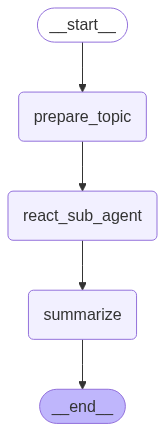

In [14]:
from IPython.display import Image, display

try:
  display(Image(parent_app.get_graph().draw_mermaid_png()))
except exception:
  pass